In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal", "Fraud"]

In [2]:
dataset = pd.read_csv("creditcard.csv")

In [3]:
# Check for any null values
print("Any nulls in the dataset", dataset.isnull().values.any())
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values", dataset.Class.unique())

# 0 is for normal credit card transaction
# 1 is for fraudulent credit card transaction
print('---------------------------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort=True))

Any nulls in the dataset False
-------
No. of unique labels  2
Label values [0 1]
---------------------------
Break down of the Normal and Fraud Transactions
0    284315
1       492
Name: Class, dtype: int64


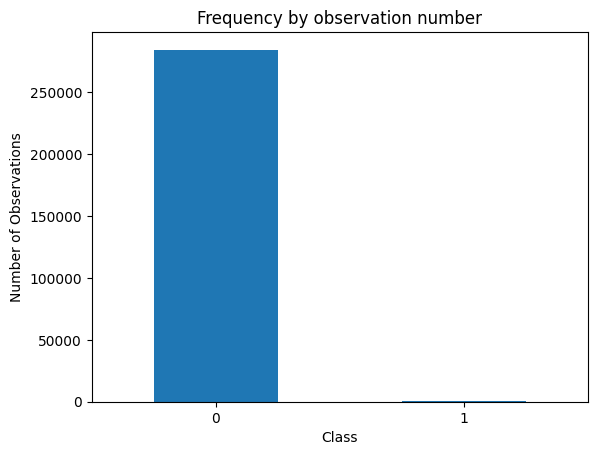

In [4]:
# Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()

In [5]:
# Save the normal and fraudulent transactions in separate dataframes
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

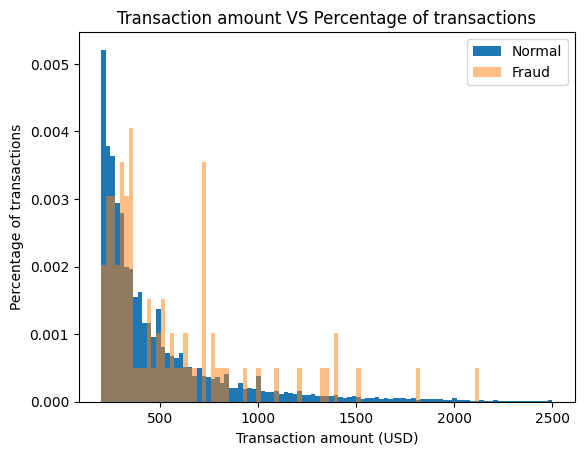

In [6]:
# Visualize transaction amounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount VS Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

In [7]:
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [8]:
raw_data = dataset.values
# The last element contains if the transaction is normal, which is represented by a 0 and 1
labels = raw_data[:, -1]
# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

In [9]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_PCT, random_state=RANDOM_SEED)

In [10]:
# Normalize the data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [11]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [12]:
# Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]

In [13]:
print("No. of records in Fraud Train Data=", len(fraud_train_data))
print("No. of records in Normal Train Data=", len(normal_train_data))
print("No. of records in Fraud Test Data=", len(fraud_test_data))
print("No. of records in Normal Test Data=", len(normal_test_data))

No. of records in Fraud Train Data= 350
No. of records in Normal Train Data= 199014
No. of records in Fraud Test Data= 142
No. of records in Normal Test Data= 85301


In [14]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

In [15]:
# Define the L2 activity regularizer
activity_regularizer = tf.keras.regularizers.l2(0.01)  # You can adjust the regularization strength

In [16]:
# Input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

In [17]:
# Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=activity_regularizer)(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2, activation=tf.nn.leaky_relu)(encoder)

In [18]:
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)


In [19]:
# Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [23]:
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="autoencoder_fraud.h5",
    mode='min',
    monitor='val_loss',
    verbose=2,
    save_best_only=True  # Set this to True to save only when the validation loss improves
)



In [25]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0001, 
    patience=10, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True)


In [26]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data,
epochs=nb_epoch,
batch_size=batch_size,
shuffle=True,
validation_data=(test_data,test_data), verbose=1,
callbacks=[cp, early_stop]
).history

Epoch 1/50
3102/3110 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.0419
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3110/3110 [==============================] - 27s 7ms/step - loss: 0.0058 - accuracy: 0.0419 - val_loss: 2.3880e-05 - val_accuracy: 0.0345
Epoch 2/50
3105/3110 [============================>.] - ETA: 0s - loss: 2.2936e-05 - accuracy: 0.0689
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
3110/3110 [==============================] - 22s 7ms/step - loss: 2.2931e-05 - accuracy: 0.0690 - val_loss: 2.3409e-05 - val_accuracy: 0.1267
Epoch 3/50
3104/3110 [============================>.] - ETA: 0s - loss: 2.2496e-05 - accuracy: 0.0665
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
3110/3110 [==============================] - 20s 6ms/step - loss: 2.2498e-05 - accuracy: 0.0665 - val_loss: 2.2693e-05 - val_accuracy: 0.0264
Epoch 4/50
3110/3110 [==============================] - ETA: 0s - loss: 2.2004e-05 - accuracy: 0.0624
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
3110/

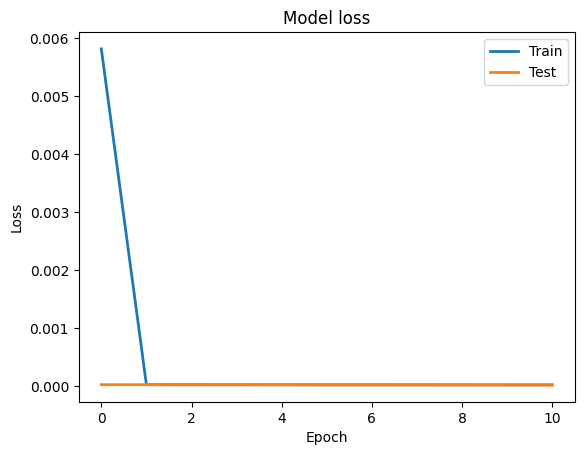

In [30]:
plt.plot(history['loss'], linewidth=2, label='Train') 
plt.plot(history['val_loss'], linewidth=2,label='Test') 
plt.legend(loc='upper right')
plt.title('Model loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch') #plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [31]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1) 
error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': test_labels})

2671/2671 [==============================] - 7s 3ms/step


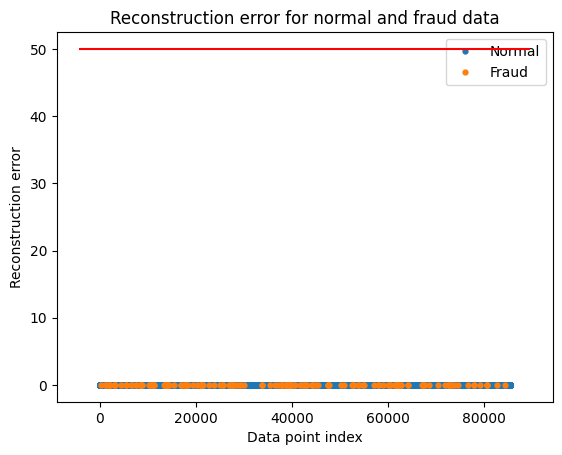

In [34]:
threshold_fixed = 50
groups = error_df.groupby('True_class') 
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100)
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error") 
plt.xlabel("Data point index") 
plt.show()

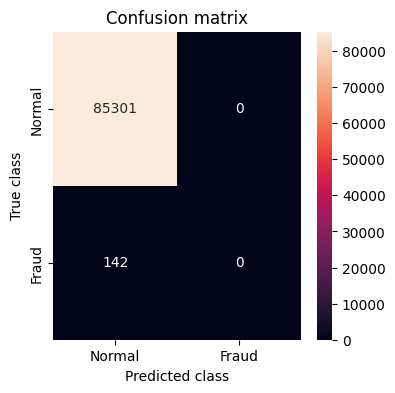

In [36]:
threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 
          for e in 
          error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [37]:
# Print Accuracy, precision, and recall
print("Accuracy: ", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall: ", recall_score(error_df['True_class'], error_df['pred']))
print("Precision:", precision_score(error_df['True_class'], error_df['pred']))

Accuracy:  0.99833807333544
Recall:  0.0
Precision: 0.0


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
